# Кофемолки Yandex.market 

Целью проекта является выяление закономерностей в ценообразовании кофемолок, которые реализуются на Яндекс.Маркете.

Для работы использовались реальные данные, которые были собраны с официального сайта Яндекс.Маркета.


**Описание данных**
* name - название товара 
* price_yand - цена товара со скидкой Яндекс.Pay (руб)
* price_full - цена товара без скидки (руб)
* color - цвет товара 
* volume - вместимость кофемолки (г)
* gr_syst - система помола кофемолки
* power - мощность кофемолки 
* rotation - особенности кофемолки либо наличие системы регулировки (данные присутствовали не по всем позициям)
* brand - бренд кофемолки 


# Этап 1. Получение и обработка данных

In [201]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 

In [140]:
df = pd.read_excel('grinders.xlsx')
del df['web-scraper-order']
del df['web-scraper-start-url']

### Прочтем данные и посмотрим на них

In [141]:
df.head(5)

,name,price_yand,price_full,color,volume,gr_syst,power,rotation
0,Кофемолка «3 в 1» Kitfort KT-799,2 342,2 390,черный,Вместимость: 40 г,Система помола: ротационный нож,Мощность: 210 Вт,Особенности: блокировка включения при снятой к...
1,Кофемолка Kitfort KT-799,2 237,NaN,черный,Вместимость: 40 г,Система помола: ротационный нож,Мощность: 210 Вт,Особенности: блокировка включения при снятой к...
2,Кофемолка Kitfort КТ-798,1 362,1 390,черный,Вместимость: 50 г,Система помола: ротационный нож,Мощность: 180 Вт,Особенности: блокировка включения при снятой к...
3,Кофемолка POLARIS PCG 2014,2 049,2 091,ченрый,Вместимость: 50 г,Система помола: ротационный нож,Мощность: 200 Вт,Особенности: блокировка включения при снятой к...
4,Кофемолка Kitfort KT-769,1 950,1 990,синий,Вместимость: 60 г,Система помола: ротационный нож,Мощность: 200 Вт,NaN


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        500 non-null    object
 1   price_yand  500 non-null    object
 2   price_full  458 non-null    object
 3   color       498 non-null    object
 4   volume      495 non-null    object
 5   gr_syst     485 non-null    object
 6   power       451 non-null    object
 7   rotation    361 non-null    object
dtypes: object(8)
memory usage: 31.4+ KB


#### Плагин выгружает данные только в формате строки, кроме того есть товары, по которым данные не представлены, поэтому обработаем данные


In [143]:
#Во-первых напишем функцию, которая будет выделять название бренда (на английском языке) из колонки name. 
#После находжения бренда по заданным критериям, его название будет добавляться в новую колонку brand.  
def extract_brand(x):
    match = re.search(r'\b[A-Za-z]+\b', x)
    if match:
        return match.group(0)
    return None
df['brand'] = df['name'].apply(extract_brand)

In [144]:
# Также сменим регистр, чтобы избежать уникальных значений одного и того же бренда из-за регистра 
df['brand'] = df['brand'].astype(str).str.lower()

#### Переменная color содержит слишком много разных цветов, что будет не совсем удобно для анализа, поэтому сократим их количество 

In [7]:
df['color'].unique()

array(['черный', 'ченрый', 'синий', '100 г', 'серебристый',
       'нержавеющая сталь', 'стальной', 'белый',
       'серый,серебристый,черный', 'серебристый/черный', 'черно-желтый',
       'серебиристый', 'черный/розовый', 'бежевый', 'серый',
       'синий сапфир', 'яркий коралл', 'чёрный', 'серебристо-черный',
       'черный/серебристый', 'бронзовый', 'коричневый',
       'нержавеющая сталь/черный', 'серебристый / черный',
       'черный/красный', 'красный', 'стальной/черный', 'black', '50 г',
       'черный жемчуг', 'белый/черный', 'черный/серебро', 'coffee',
       'черный/золотистый', 'Ночной графит', 'белый/синий', '390 г',
       'бирюзовый', 'черный/нержавеющая сталь', 'серый/черный', 'лиловый',
       'золото', 'серый / серебристый', 'белый жемчуг', 'красный рубин',
       'белый/красный', 'черный / серебристый', 'металлик/черный',
       'серый/серебристый', '60 г', 'белый с бежевым', 'сладкая слива',
       'ясная яшма', 'фиолетовый', 'белый/бежевый', 'черный..', 'white',
   

In [145]:
#Зададим условия, чтобы функция присваивала значения по соответствующим признакам
conditions = [
    (['че','чё','sch','bl','Но', 'чeрный'], 'черный'),
    (['си'], 'синий'),
    (['бел', 'wh'], 'белый'),
    (['се', 'grey'], 'серый')]
# Функция для замены цветов
def replace_color(x):
    for keywords, color in conditions:
        if any(re.search(keyword, str(x), re.IGNORECASE) for keyword in keywords):
            return color
    return 'другой'
# Применяем функцию к столбцу 'color'
df['color'] = df['color'].apply(replace_color)

In [138]:
df.color.unique()

array([5, 4, 3, 1, 2], dtype=int64)

In [160]:
df.color.value_counts()

color
черный    213
серый     120
другой     88
белый      61
синий      18
Name: count, dtype: int64

In [146]:
col_n = {
    'другой': 1,
    'белый': 2,
    'серый': 3,
    'синий': 4,
    'черный': 5
}
# Создаем новую колонку с закодированными значениями
df['color_n'] = df['color'].replace(col_n)

#### На примере столбца color можно заметить, что некоторые значения находятся не в тех колонках (85 г, 6 Вт), поэтому напишем функцию, которая будет проверять столбец на соответствие определенному признаку, после чего 'правильные' значения будут перенесены в новые колонки 

In [147]:
def correct_data(row):
    for col in row.index:
        value = row[col]
        if pd.isna(value):
            continue
        value_str = str(value)
        # Проверка и создание новой колонки для volume
        if re.match(r'(Вместимость: \d+ г|\d+ г)$', value_str):
            if pd.isna(row['c_volume']):
                row['c_volume'] = value
        # Проверка и создание новой колонки для gr_syst
        if "Система помола:" in value_str:
            if pd.isna(row['c_gr_syst']):
                row['c_gr_syst'] = value
        # Проверка и создание новой колонки для power
        if re.match(r'(Мощность: \d+ Вт|\d+ Вт)$', value_str):
            if pd.isna(row['c_power']):
                row['c_power'] = value
        # Проверка и создание новой колонки для rotation
        if re.match(r'(Особенности: .*|Регулировка степени помола:.*)', value_str):
            if pd.isna(row['c_rotation']):
                row['c_rotation'] = value
    return row
df['c_volume'] = None
df['c_gr_syst'] = None
df['c_power'] = None
df['c_rotation'] = None
# Применим функцию ко всем строкам DataFrame
df = df.apply(correct_data, axis=1)

Далее приведем все колонки к формату float, а также удалим старые колонки

In [148]:
df['price_yand'] = df['price_yand'].apply(lambda x: str(x).replace('\u2009', ''))
df['price_full'] = df['price_full'].apply(lambda x: str(x).replace('\u2009', ''))
df.fillna(0, inplace=True)

In [149]:
df['c_volume'] = df['c_volume'].str.extract(r'(\d+)').astype(float)
df['c_power'] = df['c_power'].str.extract(r'(\d+)').astype(float)
df[['price_yand','price_full']] = df[['price_yand','price_full']].astype(float)

In [150]:
df = df.drop(columns=['volume','gr_syst','power','rotation'])

In [151]:
# Если значения price_full отсутствует, то оно равно price_yandex
df['price_full'] = df['price_full'].fillna(df['price_yand'])

In [162]:
# Значения в колонке gr_syst имеют разные форматы, поэтому приведем их к одному формату
def grind_system(value):
    if value in [0, '0']:
        return 'Система неизвестна'
    value = value.lower()
    if 'ротацион' in value:
        return 'Система помола: ротационный нож'
    if 'жернова' in value:
        return 'Система помола: жернова'
    if 'ножев' in value:
        return 'Система помола: ротационный нож'
    return value
df['c_gr_syst'] = df['c_gr_syst'].apply(grind_system)
# Также зададим системам помола числовые значения, чтобы использовать их в регрессии
mapping = {
    'система неизвестна': 0,
    'Система помола: ротационный нож': 0,
    'Система помола: жернова': 1
}
# Создаем новую колонку с закодированными значениями
df['gr_numb'] = df['c_gr_syst'].replace(mapping)

In [163]:
df['gr_numb'].unique()

array([0, 1], dtype=int64)

Мы закодировали значения 'система неизвестна' как 0 из допушения, что кофемолки без информации о системе помола являются дешевыми и у них не может быть жерновой системы. То, что они дешевые подтверждается в коде ниже.

In [65]:
df[df['c_gr_syst'] == 'система неизвестна'].price_yand.median()

799.0

In [66]:
df[df['c_gr_syst'] == 'система неизвестна'].price_yand.mean()

1169.225806451613

In [67]:
df[df['c_gr_syst'] == 'Система помола: жернова'].price_yand.mean()

10452.795275590552

In [68]:
df[df['c_gr_syst'] == 'Система помола: жернова'].price_yand.median()

5478.0

В итоге получаем обработанные данные, которые можно удобно анализировать

In [153]:
df.head()

,name,price_yand,price_full,color,brand,color_n,c_volume,c_gr_syst,c_power,c_rotation,gr_numb
0,Кофемолка «3 в 1» Kitfort KT-799,2342.0,2390.0,черный,kitfort,5,40.0,Система помола: ротационный нож,210.0,Особенности: блокировка включения при снятой к...,0
1,Кофемолка Kitfort KT-799,2237.0,2237.0,черный,kitfort,5,40.0,Система помола: ротационный нож,210.0,Особенности: блокировка включения при снятой к...,0
2,Кофемолка Kitfort КТ-798,1362.0,1390.0,черный,kitfort,5,50.0,Система помола: ротационный нож,180.0,Особенности: блокировка включения при снятой к...,0
3,Кофемолка POLARIS PCG 2014,2049.0,2091.0,черный,polaris,5,50.0,Система помола: ротационный нож,200.0,Особенности: блокировка включения при снятой к...,0
4,Кофемолка Kitfort KT-769,1950.0,1990.0,синий,kitfort,4,60.0,Система помола: ротационный нож,200.0,0,0


# Этап 2. Описательная статистика 


По результатам функции describe можно сделать вывод, что в основном на Яндекс.Маркете реализуются кофемолки низкого и среднего ценовых сегментов. Среднее составляет 4277.98, а медиана лишь 1959.5, это значит, что 50% кофемолок дешевле 1959.5.
Кроме того, квартиль 75% также меньше среднего и составляет 3299.7, это значит, что лишь 25% кофемолок дороже этой суммы.

Объем кофемолки в среднем составялет 120 граммов, медиана составляет лишь 70 граммов, что также объясняется наличием большого количества недорогих кофемолок в выборке. 

Мощность в среднем составляет 223 Ватта, медиана составляет 200 Ваттов.

Скидка по карте yandex pay в среднем составляет 1.83%. 

In [164]:
df.describe()

,price_yand,price_full,color_n,c_volume,c_power,gr_numb
count,500.00000,500.000000,500.000000,461.000000,475.000000,500.000000
mean,4277.98800,4352.602000,3.414000,120.559653,223.120000,0.254000
std,8687.47164,8818.235915,1.549001,166.669652,149.792755,0.435734
min,505.00000,515.000000,1.000000,25.000000,13.000000,0.000000
25%,1365.00000,1390.000000,2.000000,50.000000,150.000000,0.000000
50%,1959.50000,1990.000000,3.000000,70.000000,200.000000,0.000000
75%,3299.75000,3332.750000,5.000000,100.000000,250.000000,1.000000
max,84136.00000,84986.000000,5.000000,1500.000000,2400.000000,1.000000


In [156]:
#Средняя скидка по карте yandex pay
(1-(df['price_yand']/df['price_full']).mean())*100

1.8310768567993074

Отсортируем некоторые показатели по брендам и среднему значению. Можно заметить, что есть бренды которые производят крайне дешевые кофемолки (меньше 1000 рублей), а также профессиональные бренды (более 20 тысяч рублей).

In [157]:
br = df.groupby(['brand'])['price_yand'].agg(['count', 'mean', 'min', 'max']).sort_values(by = 'mean')
br

,count,mean,min,max
brand,,,,
beaika,1,723.000000,723.0,723.0
maxtronic,1,796.000000,796.0,796.0
lira,1,798.000000,798.0,798.0
chef,2,867.500000,728.0,1007.0
do,1,910.000000,910.0,910.0
...,...,...,...,...
cunill,1,29833.000000,29833.0,29833.0
saeco,2,42100.000000,42100.0,42100.0
eureka,2,48440.000000,19580.0,77300.0


Далее отсортируем бренды по количеству представленных позиций. Наиболее часто встречается бренд kitfort (83 раза), также существует 56 позиций без бренда - это дешевые кофемолки без бренда.  

In [158]:
br1 = df.groupby(['brand'])['price_yand'].agg(['count', 'mean', 'min', 'max']).sort_values(by = 'count')
br1

,count,mean,min,max
brand,,,,
airhot,1,7917.000000,7917.0,7917.0
rondell,1,5237.000000,5237.0,5237.0
maxtronic,1,796.000000,796.0,796.0
fragrant,1,2244.000000,2244.0,2244.0
pcg,1,1510.000000,1510.0,1510.0
...,...,...,...,...
kelli,15,1132.333333,826.0,1825.0
sakura,15,2178.533333,992.0,6901.0
marta,25,1239.760000,505.0,3331.0


Далее, посчитаем корреляции между переменными. Наибольшие корреляции наблюдаются между перемеными price_yand и c_volume, price_yand и gr_numb, c_volume и gr_numb. 

In [166]:
corr_mat = df[['price_yand','price_full','c_volume','c_power', 'gr_numb', 'color_n']].corr().round(3)
corr_mat

,price_yand,price_full,c_volume,c_power,gr_numb,color_n
price_yand,1.000,1.000,0.792,0.090,0.415,0.021
price_full,1.000,1.000,0.793,0.089,0.416,0.022
c_volume,0.792,0.793,1.000,0.177,0.428,0.058
c_power,0.090,0.089,0.177,1.000,-0.123,-0.107
gr_numb,0.415,0.416,0.428,-0.123,1.000,0.206
color_n,0.021,0.022,0.058,-0.107,0.206,1.000


<Axes: >

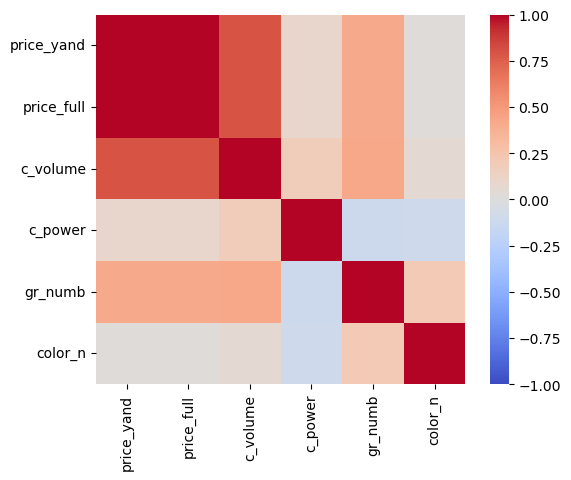

In [167]:
sns.heatmap(corr_mat, square = True,vmin = -1, vmax = 1, cmap = 'coolwarm')

Построим графики всех переменных, на них мы также можем заметить наличие связи между переменными. 

C:\Users\kazar\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


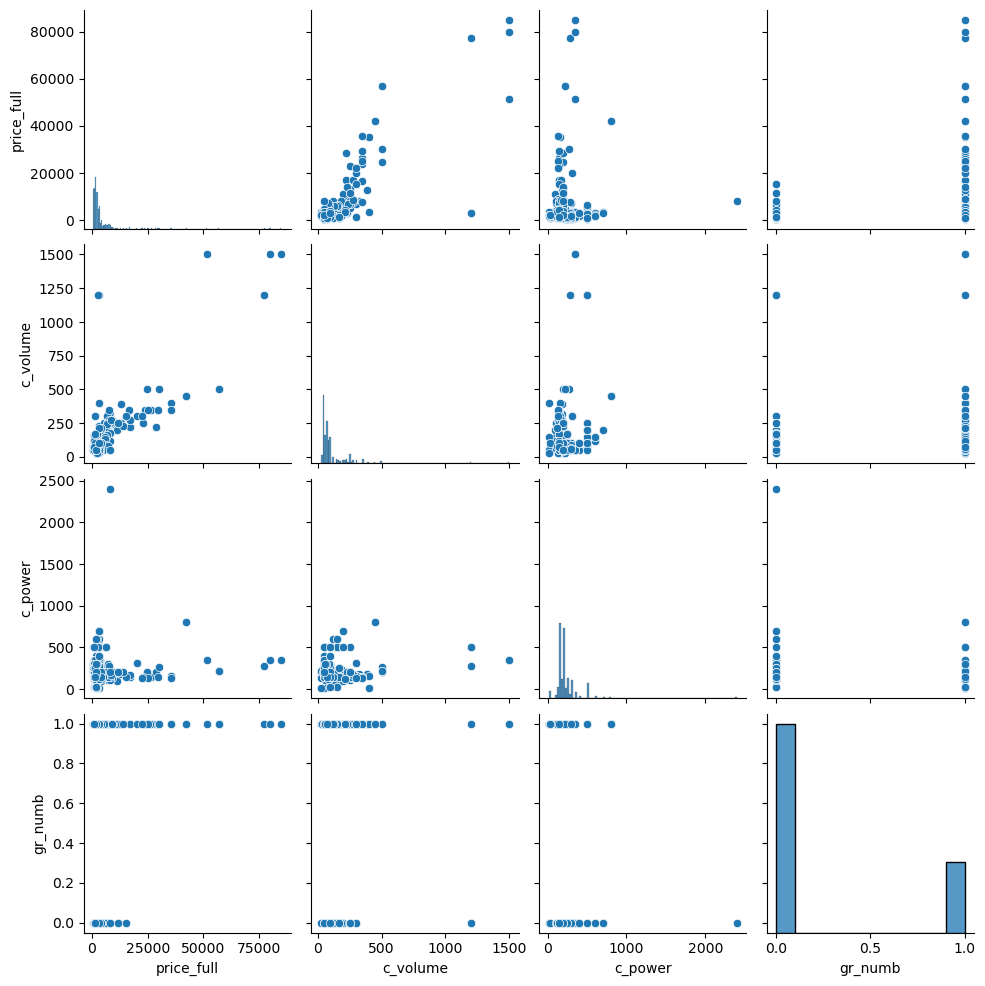

In [74]:
sns.pairplot(data = df[['price_full','c_volume','c_power','gr_numb']], diag_kind = 'hist')
pass

Построим график между переменными c_volume и price_full, которые показали наибольшую корреляцию, кроме того проведем линию регрессии

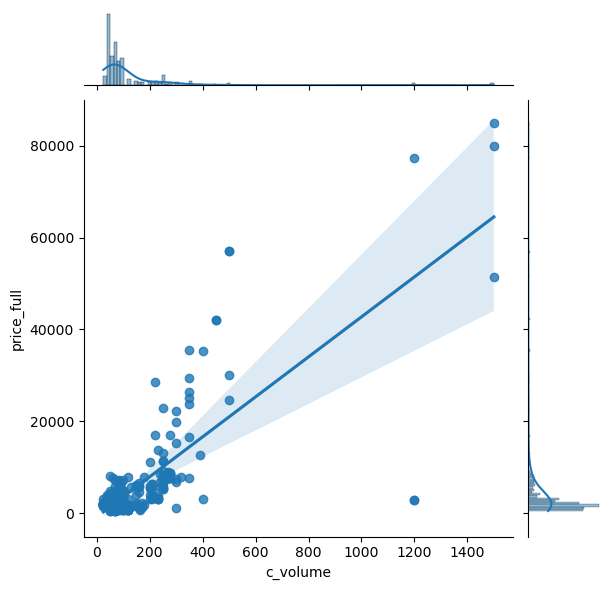

In [70]:
sns.jointplot(x = 'c_volume', y = 'price_full', kind = 'reg', data = df)

На данном графике можно заметить, что кофемолки с жерновой системой помола чаще имеют большие объем и цену. 

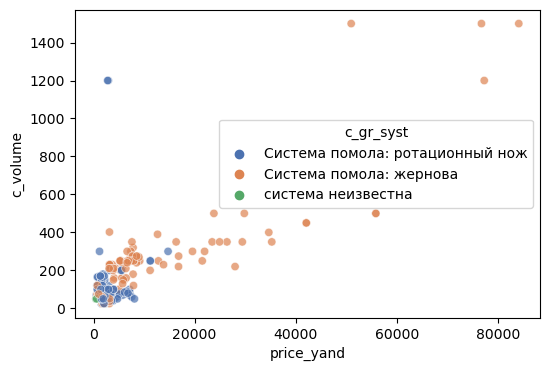

In [75]:
plt.figure(figsize = (6,4))
sns.scatterplot(x = 'price_yand', y = 'c_volume', hue = 'c_gr_syst',data = df, alpha = 0.7,  palette="deep")
pass

In [375]:
df[df['gr_numb'] == 1].price_yand.mean() # также можно провести t-test о равенстве средних меджу группами 

10452.795275590552

In [376]:
df[df['gr_numb'] == 0].price_yand.mean()

2175.573726541555

Синюю точку с вместимостью 1200 граммов можно принять за выброс, однако это действительно кофемолка с большой вместимостью и системой 'ротационный нож', поэтому её цена достаточно низкая

In [107]:
df[(df['c_volume'] > 800) & (df['price_yand'] < 20000)]

,name,price_yand,price_full,color,brand,c_volume,c_gr_syst,c_power,c_rotation,gr_numb,pred_price
11,Кофемолка Kitfort КТ-776,2930.0,2990.0,черный,kitfort,1200.0,Система помола: ротационный нож,500.0,Регулировка степени помола: есть,0,47133.470037
109,Кофемолка Kitfort КТ-776,2803.0,2890.0,черный,kitfort,1200.0,Система помола: ротационный нож,500.0,Регулировка степени помола: есть,0,47133.470037


## Этап 3. Регрессионный анализ 

Удалим Na значения, потому что функция sm.OLS не может работать с ними 

In [168]:
df1 = df.dropna()

In [185]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 452 entries, 0 to 498
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   name        452 non-null    object 
 1   price_yand  452 non-null    float64
 2   price_full  452 non-null    float64
 3   color       452 non-null    object 
 4   brand       452 non-null    object 
 5   color_n     452 non-null    int64  
 6   c_volume    452 non-null    float64
 7   c_gr_syst   452 non-null    object 
 8   c_power     452 non-null    float64
 9   c_rotation  452 non-null    object 
 10  gr_numb     452 non-null    int64  
 11  pred_price  452 non-null    float64
dtypes: float64(5), int64(2), object(5)
memory usage: 62.1+ KB


Сначала построим линейную регрессию, где зависимой переменной (y) будет выступать цена кофемолки (price_yand), а независимыми переменными (x) вместимость, система помола и мощность  

In [312]:
X = df1[['c_volume', 'gr_numb', 'c_power']]
Y = df1['price_yand']
X = sm.add_constant(X)
reg_res = sm.OLS(Y, X).fit()
reg_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_yand   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     263.8
Date:                Wed, 03 Jul 2024   Prob (F-statistic):           1.35e-98
Time:                        19:12:53   Log-Likelihood:                -4530.8
No. Observations:                 452   AIC:                             9070.
Df Residuals:                     448   BIC:                             9086.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -969.8425    619.966     -1.564      0.118   -2188.246     248.561
c_volume      40.1760      1.771     22.682      0.000      36.695      43.657
gr_numb     2409.7644    687.291      3.506      0.001    1059.050    3760.479
c_power       -0.2508      2.509     -0.100      0.920      -5.182       4.680
==============================================================================
Omnibus:                      150.130   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14828.769
Skew:                          -0.243   Prob(JB):                         0.00
Kurtosis:                      31.056   Cond. No.                         833.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Модель в целом являеться статистически значимой (overall significant), так как Prob (F-statistic) < 0.05

Коэффициенты c_volume и gr_numb является статистически значимыми ну уровне значимости 5% (p-value < 0.05), поэтому мы можем иъ интерпретировать. 

При увеличении вместимости (c_volume) на 1 г, цена кофемолки в среднем увеличивается на 40.17 рублей. 

Если кофемолка имеет жерновую систему помола (gr_numb), то её цена в среднем увеличивается на 2409 рублей. 

R^2 составляет 0.63, регрессоры объясняют 63% дисперсий зависимой переменой. 

In [271]:
v_max = df1['c_volume'].max()
g_max = df1['gr_numb'].max()
p_max = df1['c_power'].max()

reg_res.predict([1, v_max, g_max, p_max])

array([61503.23797812])

Попробуем предсказать цену кофемолки при максимальных значениях регрессеров. В таком случае её цена составит 61503 рублей. 


In [272]:
pred1 = reg_res.predict(X)
df1['pred_price'] = pred1

C:\Users\kazar\AppData\Local\Temp\ipykernel_2196\2404119300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['pred_price'] = pred1


Далее предскажем все значения в датасете и добавим их в df1 

In [273]:
df1.head()

,name,price_yand,price_full,color,brand,color_n,c_volume,c_gr_syst,c_power,c_rotation,gr_numb,pred_price
0,Кофемолка «3 в 1» Kitfort KT-799,2342.0,2390.0,черный,kitfort,5,40.0,Система помола: ротационный нож,210.0,Особенности: блокировка включения при снятой к...,0,584.521398
1,Кофемолка Kitfort KT-799,2237.0,2237.0,черный,kitfort,5,40.0,Система помола: ротационный нож,210.0,Особенности: блокировка включения при снятой к...,0,584.521398
2,Кофемолка Kitfort КТ-798,1362.0,1390.0,черный,kitfort,5,50.0,Система помола: ротационный нож,180.0,Особенности: блокировка включения при снятой к...,0,993.806397
3,Кофемолка POLARIS PCG 2014,2049.0,2091.0,черный,polaris,5,50.0,Система помола: ротационный нож,200.0,Особенности: блокировка включения при снятой к...,0,988.789666
4,Кофемолка Kitfort KT-769,1950.0,1990.0,синий,kitfort,4,60.0,Система помола: ротационный нож,200.0,0,0,1390.549568


В соответствии с предсказанными значениями, сумма ошибок близится к нулю 

In [274]:
sum(df1['price_yand']-df1['pred_price'])

1.7471393221057951e-09

Далее, уберем статистически незначимый регрессор (c_power) из модели. Оказалось, что значение информационного критерия Акаике (AIC) в новой модели меньше (9068<9070), соотвественно модель reg_res1 более предпочтительна. 

In [315]:
X1 = df1[['c_volume', 'gr_numb']]
Y1 = df1['price_yand']
X1 = sm.add_constant(X1)
reg_res1 = sm.OLS(Y1, X1).fit()
reg_res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             price_yand   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     396.6
Date:                Wed, 03 Jul 2024   Prob (F-statistic):          6.04e-100
Time:                        19:13:50   Log-Likelihood:                -4530.8
No. Observations:                 452   AIC:                             9068.
Df Residuals:                     449   BIC:                             9080.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1022.5300    326.089     -3.136      0.002   -1663.380    -381.680
c_volume      40.1300      1.709     23.487      0.000      36.772      43.488
gr_numb     2425.4372    668.432      3.629      0.000    1111.794    3739.080
==============================================================================
Omnibus:                      150.353   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14837.747
Skew:                          -0.249   Prob(JB):                         0.00
Kurtosis:                      31.064   Cond. No.                         542.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Исходя их этого, можно сделать вывод, что вместимость и система помола кофемолки оказывают статистически значимое влияение на цену.

#### Логистическая регрессия 

Далее, построим модель логистической регрессии для переменной gr_numb. С помощью нее мы узнаем какие факторы влияют на систему помола кофемолки. 

In [377]:
# Разделим датасет на тренировочную и тестовую выборки. 
train_data, test_data = train_test_split(df1, test_size = 0.5, random_state = 42)
train_data.head()

,name,price_yand,price_full,color,brand,color_n,c_volume,c_gr_syst,c_power,c_rotation,gr_numb,pred_price,pred_price1
248,Кофемолка Redmond CG800,12670.0,12798.0,черный,redmond,5,390.0,Система помола: жернова,180.0,Регулировка степени помола: есть,1,17063.407509,17053.607183
99,Кофемолка Kitfort KT-769,2078.0,2099.0,синий,kitfort,4,60.0,Система помола: ротационный нож,200.0,0,0,1390.549568,1385.270029
286,"Кофемолка Добрыня DO-3701, черный..",910.0,919.0,черный,do,5,50.0,Система помола: жернова,200.0,Особенности: блокировка включения при снятой к...,1,3398.554105,3409.407180
70,Кофемолка электрическая мельница для специй Ke...,872.0,890.0,белый,kelli,2,70.0,Система помола: ротационный нож,300.0,Особенности: блокировка включения при снятой к...,0,1767.225814,1786.570029
24,"Кофемолка Bosch TSM6A01, черный",2778.0,2834.0,черный,bosch,5,75.0,Система помола: ротационный нож,180.0,Особенности: блокировка включения при снятой к...,0,1998.206152,1987.220029


In [206]:
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit

In [222]:
#Зададим формулу для регрессии 
formula = 'gr_numb ~ price_yand + c_volume + c_power'

In [244]:
#Строим модель  
model = logit(formula = formula, data = train_data).fit()

Optimization terminated successfully.
         Current function value: 0.366752
         Iterations 8


Псевдо коэффициент детерминации составляет 0.37. 

Коэффициенты price_yand, c_volume, c_power оказались статистически значимыми на уровне значимости 5% (p-value < 0.05), поэтому мы можем их интерпретировать. 
Из-за того, что используется логистическая регрессия, можно интерпретировать только знаки коэффциентов:
1) При увеличении цены товара на 1 рубль, вероятность наличия жерновой системы помола (1) увеличивается 
2) При увеличении вместимости товара на 1 грамм, вероятность наличия жерновой системы помола (1) увеличивается 
3) При увеличении мощности товара на 1 Ватт, вероятность наличия жерновой системы помола (1) уменьшается.

In [320]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                gr_numb   No. Observations:                  226
Model:                          Logit   Df Residuals:                      222
Method:                           MLE   Df Model:                            3
Date:                Wed, 03 Jul 2024   Pseudo R-squ.:                  0.3711
Time:                        19:22:35   Log-Likelihood:                -82.886
converged:                       True   LL-Null:                       -131.80
Covariance Type:            nonrobust   LLR p-value:                 4.570e-21
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.2471      0.733     -1.700      0.089      -2.685       0.190
price_yand     0.0002      0.000      2.454      0.014       5e-05       0.000
c_volume       0.0074      0.003      2.324      0.020       0.001       0.014
c_power       -0.0087      0.003     -2.487      0.013      -0.016      -0.002
==============================================================================
"""

In [210]:
from sklearn.metrics import classification_report, accuracy_score

Далее, сделаем предсказания на тестовой подвыборке и вычислим accuracy модели

In [332]:
prediction = model.predict(exog = test_data)
y_actual = test_data['gr_numb']

In [349]:
cutoff = 0.5
y_pred = np.where(prediction > cutoff, 1, 0)
accuracy = accuracy_score(y_actual, y_pred)
print(accuracy)

0.8805309734513275


In [372]:
cutoff1 = 0.32
y_pred1 = np.where(prediction > cutoff1, 1, 0)
accuracy1 = accuracy_score(y_actual, y_pred1)
print(accuracy1)

0.915929203539823


In [361]:
df1.gr_numb.value_counts()

gr_numb
0    342
1    110
Name: count, dtype: int64

In [371]:
len(df1[(df1['gr_numb'] == 1)])/len(df1[(df1['gr_numb'] == 0)])

0.3216374269005848

Лучший performance модель показывается, когда cut-off value равен 32%. Это происходит из-за того, что в выборке существует проблема sample imbalance: класс 1 составляет лишь 32% от класса 0.

## Этап 4. Рекомендации 

1) Покупатели, которые хотят сэкономить на покупке кофемолки должны выбирать кофемолку с ротационной системой помола: цены на такие кофемолки в среднем ниже, чем с жерновой системой 
2) Покупатели, которые хотят сэкономить на покупке кофемолки должны выбирать кофемолку небольшой вместимостью.
3) Покупатели могут не учитывать мощность кофемолки при покупке, так как она не оказывает влияния на цену.
4) Большие цена и вместимость увеличивают вероятность кофемолки иметь жерновую систему помола, поэтому при 'слепом' выборе можно использоваться эти критерии. 